# Generate communication network


This notebook contains the workflow to simplify the technical knudepunkter network (raw input data from GeoFA) into the "communication" network where we only have 1 node at each intersection, and only 1 edge at each street (i.e. no parallel lines even when network runs on both sides of a street, etc.)

Final output: a gdf which can be directly converted into a simplfied network by `momepy.gdf_to_nx` (see notebook [`read-network.ipynb`](./read-network.ipynb) for sample code)

Network is simplified with [`sgeop`](https://github.com/uscuni/sgeop.git) (bleeding edge), setting `artifact_threshold` manually

### To run for entire DK, change input folder like:

```python
edges = gpd.read_file('../data/network-technical/cykelknudepunktsstraekninger-all/cykelknudepunktsstraekninger.gpkg')
```

### To Do: Automate data download?

**todo: check whether we can get data from [here](https://geofa-kort.geodanmark.dk/app/fkg/?config=/api/v2/configuration/fkg/configuration_fkg_udgivet_5f465f5d3181f687353260.json#Basis_kort/11/12.0939/55.2226/fkg.t_5609_cykelknudepunktsstraekninger,fkg.t_5608_cykelknudepunkter) and what the difference is**

(https://geofa.geodanmark.dk/ows/fkg/fkg)

if so: start with `./src/wfs-func.py`, we already have some functions defined there for WFS import

In [1]:
# import libraries
import os
import pandas as pd
import geopandas as gpd
import momepy
import networkx as nx
import matplotlib.pyplot as plt
import sgeop
import momepy

make folders for output

In [2]:
os.makedirs("../data/network-communication/", exist_ok=True)

define parameters

In [2]:
# define parameters
proj_crs = 'EPSG:25832' # in meters

load input data

In [4]:
# load "technical" files
edges = gpd.read_file('../data/network-technical/cykelknudepunktsstraekninger/cykelknudepunktsstraekninger.gpkg')
edges = edges[["geometry"]]
edges = edges.to_crs(proj_crs)

/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [5]:
# preprocess edges for sgeop input
edges = gpd.GeoDataFrame(
    {
        "geometry": edges.geometry.explode()
    },
    crs = proj_crs
)
# removing duplicated and overlapping geoms
edges = edges[~edges.geometry.duplicated()].reset_index(drop=True)
edges_union = edges.union_all()
edge_geoms = [g for g in edges_union.geoms]
edges = gpd.GeoDataFrame(
    {
        "geometry": edge_geoms,
    },
    crs = proj_crs
)


In [10]:
# simplify
edges_simp = sgeop.simplify_network(
    roads=edges,
    artifact_threshold=12 # set manually!
)

/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/sgeop/geometry.py:227: UserWarning: Could not create a connection as it would lead outside of the artifact.
  additions, splits = snap_to_targets(


In [11]:
# save to file
edges_simp.to_file("../data/network-communication/edges.gpkg")

In [8]:
os.listdir("../../")

['install_pyqgis.sh',
 '.DS_Store',
 'LICENSE',
 'environment.yml',
 'changelog.md',
 'config',
 'docs',
 'README.md',
 'setup.py',
 '.gitignore',
 'scripts',
 'input-for-bike-node-planner',
 '.git',
 'data',
 'config-layers-linestring.yml',
 'src.egg-info',
 'src']

In [ ]:
# edges_simp = gpd.read_file("../../data/network-communication/geofa/edges.gpkg")

In [10]:
G = momepy.gdf_to_nx(gdf_network = edges_simp, multigraph=False, integer_labels=True)
comps = [c for c in nx.connected_components(G)]
print(f"Number of components: {len(comps)}")

Number of components: 6


**exploring separate components**

In [11]:
comps = sorted(comps, key=len)
gdfs=[]
for i, c in enumerate(comps):
    gdf = momepy.nx_to_gdf(nx.subgraph(G, c), points = False)
    gdf["comp"] = i
    gdfs.append(gdf)
gdfs = pd.concat(gdfs).reset_index(drop=True)

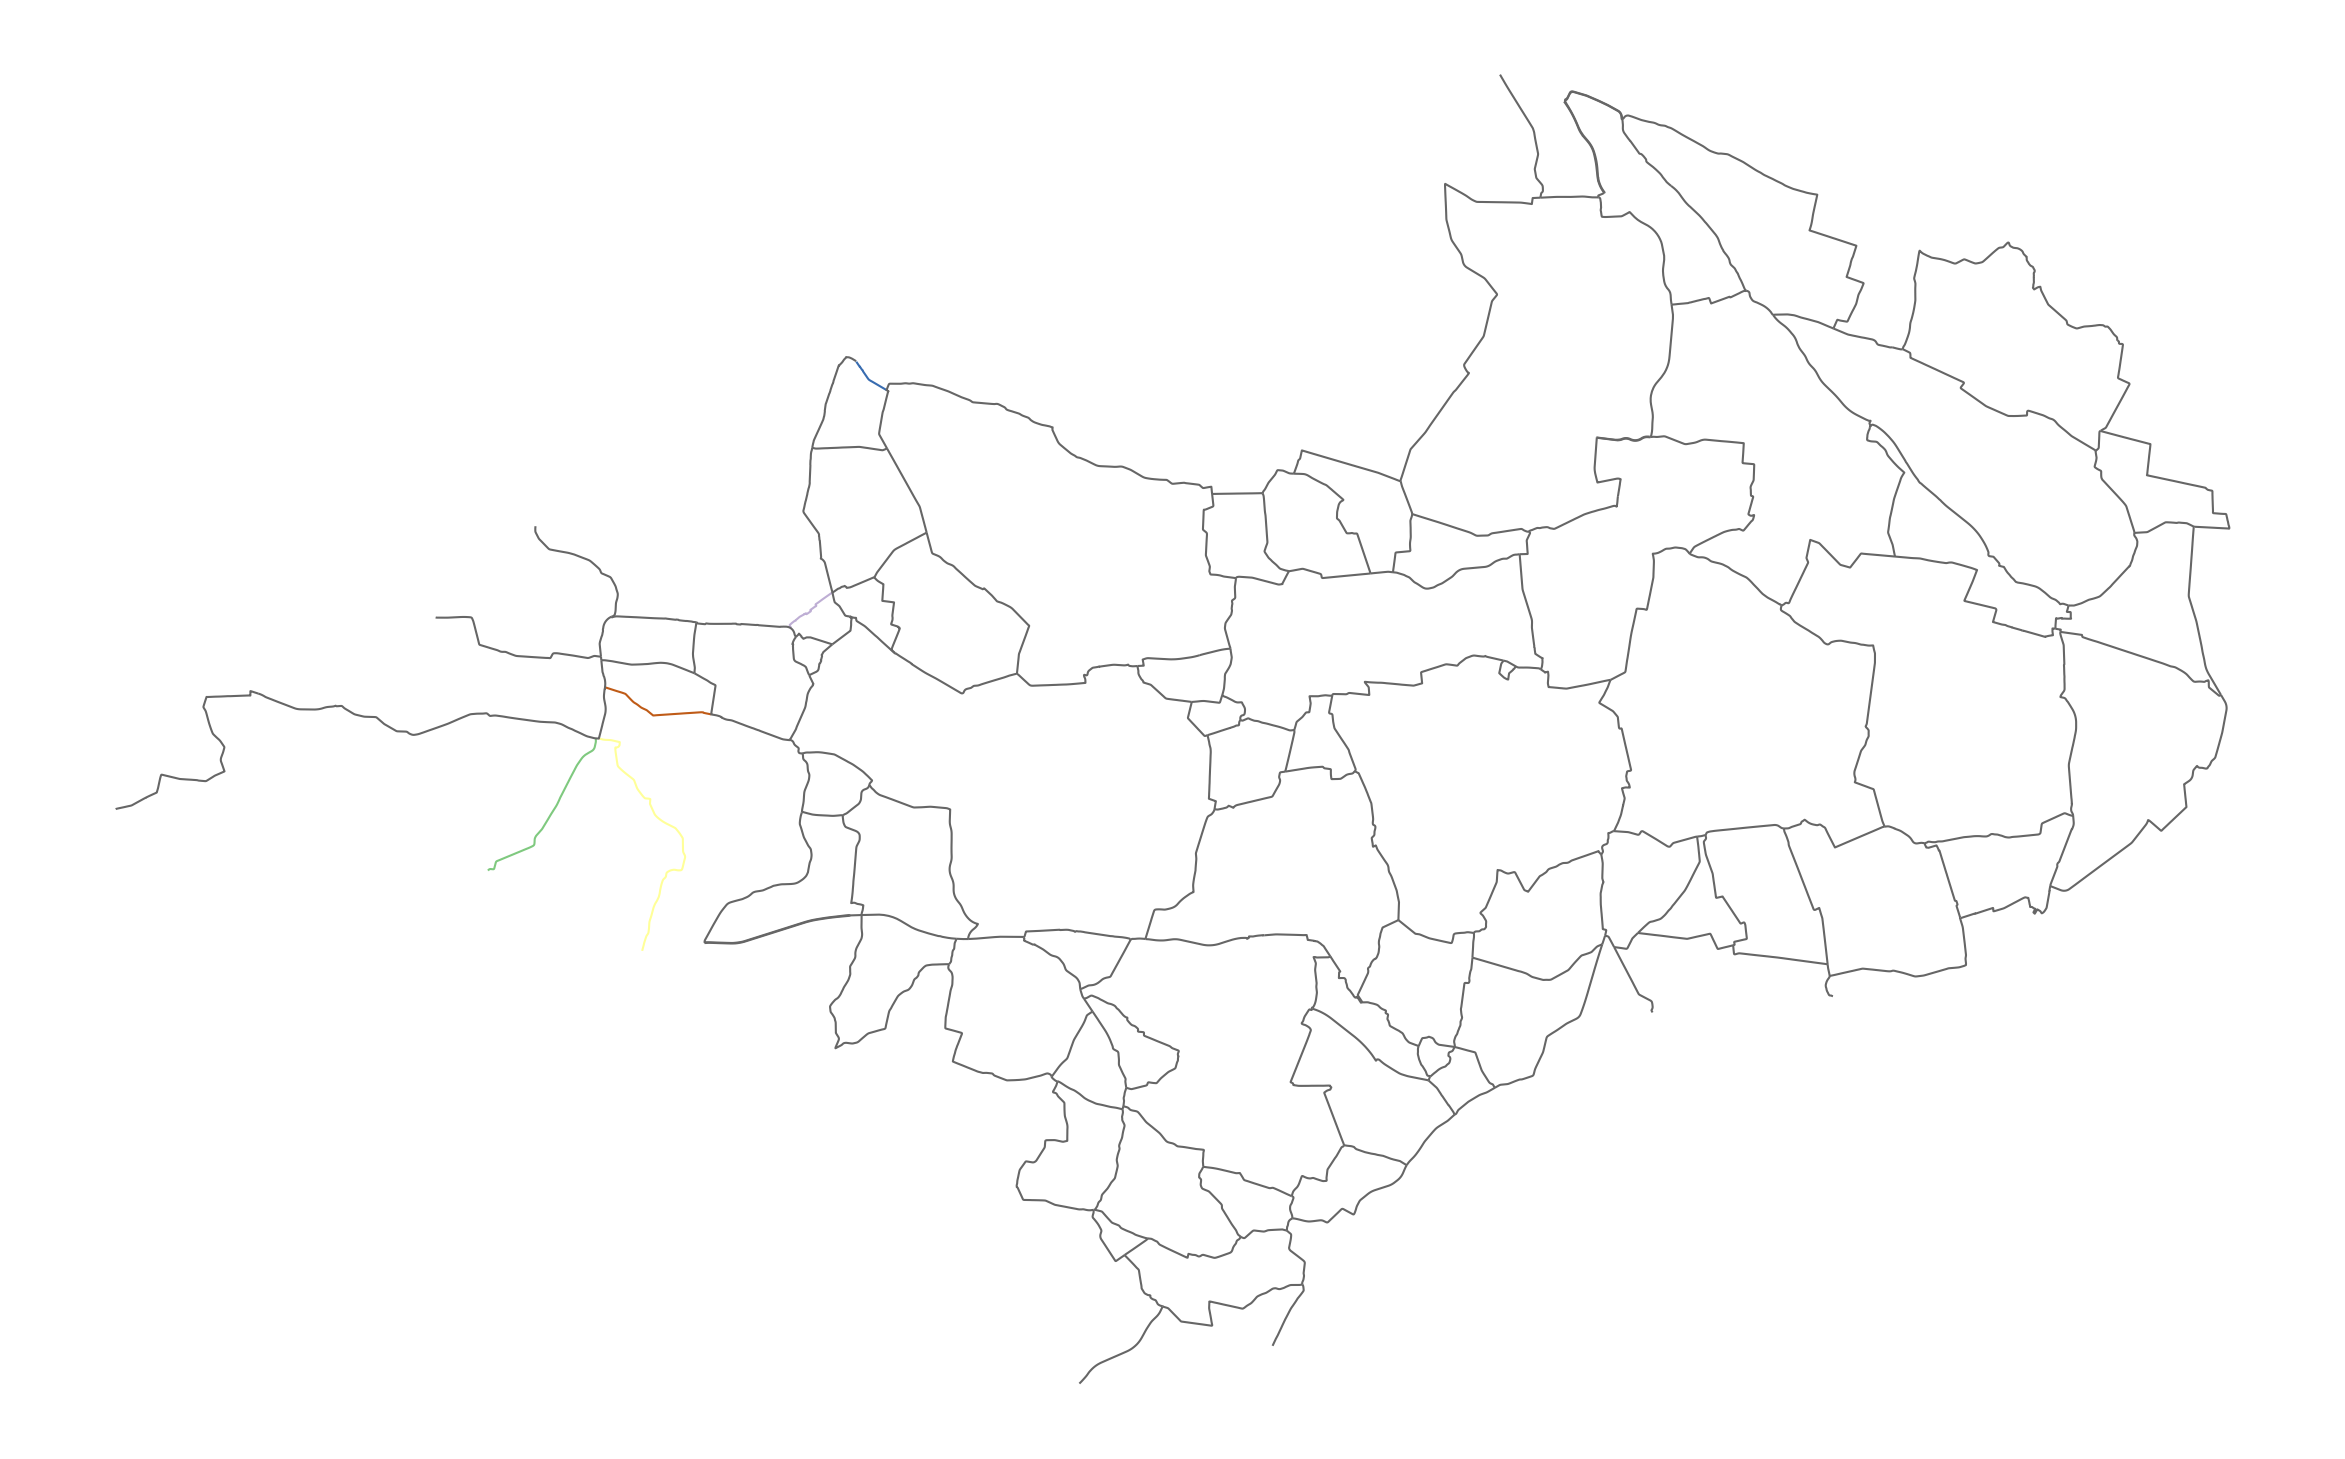

In [12]:
fig, ax = plt.subplots(1,1, figsize = (30,30))
gdfs.plot(ax=ax, column="comp", cmap = "Accent")
ax.set_axis_off()